In [1]:
!pip install pymorphy2
!pip install stop-words


     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 8.2MB 17.0MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-cp37-none-any.whl size=32917 sha256=dce28b1707275e741f1810baa15ec0de44b095a50a84b34c26618cf11fd3aa0f
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec, FastText

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import utils
from tensorflow.keras import callbacks

In [3]:
df_train = pd.read_csv('../content/drive/MyDrive/Colab_data/data/train.csv')
df_test = pd.read_csv('../content/drive/MyDrive/Colab_data/data/test.csv')
df_val = pd.read_csv('../content/drive/MyDrive/Colab_data/data/val.csv')

df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [4]:
sw = set(get_stop_words('ru'))
exclude = set(punctuation)
morpher = MorphAnalyzer()

root_train = '../content/drive/MyDrive/Colab_data/data/prep_data_train.pkl'
root_val = '../content/drive/MyDrive/Colab_data/data/prep_data_val.pkl'
root_test = '../content/drive/MyDrive/Colab_data/data/prep_data_test.pkl'

In [5]:
def preprocess_text(txt):
    txt = str(txt)
    txt = ''.join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    txt = [word for word in txt if word.isalnum()]
    return txt

In [6]:
#df_train['text'] = df_train['text'].apply(preprocess_text)
#df_val['text'] = df_val['text'].apply(preprocess_text)
#df_test['text'] = df_test['text'].apply(preprocess_text)

df_train.to_pickle(root_train)
df_val.to_pickle(root_val)
df_test.to_pickle(root_test)

In [7]:
df_train = pd.read_pickle(root_train)
df_val = pd.read_pickle(root_val)
df_test = pd.read_pickle(root_test)

df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [8]:
y_train_cat = utils.to_categorical(df_train['class'], num_classes=2)
y_val_cat = utils.to_categorical(df_val['class'], num_classes=2)

print(y_train_cat[:5])
print(y_train_cat.shape)

print(y_val_cat[:5])
print(y_val_cat.shape)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
(181467, 2)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
(22683, 2)


In [9]:
MAX_LEN = 30


In [10]:
w2v = Word2Vec(sentences=df_train['text'], size=20, window=5, min_count=1, workers=4)
w2v.save("word2vec.model")
w2v = Word2Vec.load("word2vec.model")

In [11]:
def text_to_wv(words, maxlen):
    result = []
    for word in words:
        if word in w2v.wv:
            result.append(list(w2v.wv[word]))
    padding = [[0]*25]*(maxlen-len(result))
    result = padding + result[-maxlen:]
    return result

In [12]:
X_train_wv = np.asarray([text_to_wv(text, MAX_LEN) for text in df_train['text']])
X_val_wv = np.asarray([text_to_wv(text, MAX_LEN) for text in df_val['text']])
X_test_wv = np.asarray([text_to_wv(text, MAX_LEN) for text in df_test['text']])

print(X_train_wv.shape)
print(X_val_wv.shape)
print(X_test_wv.shape)

(181467, 30, 20)
(22683, 30, 20)
(22684, 30, 20)


1. построить свёрточные архитектуры

,filter N8,filter N16,filter N32,filter N64
epochs,,,,
0,0.114802,0.112426,0.121817,0.105620
1,0.108136,0.113841,0.104221,0.110560
2,0.105735,0.105670,0.107908,0.106916
3,0.104624,0.102453,0.101258,0.100467
4,0.107060,0.105091,0.100847,0.099393
5,0.105197,0.102963,0.101682,0.099688
6,0.103798,0.102912,0.100655,0.106451
7,0.104381,0.103164,0.101375,0.099486
8,0.107065,0.102135,0.098563,0.097724


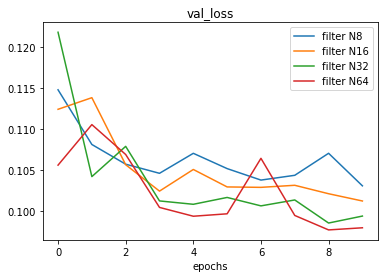

In [13]:
BATCH_SIZE = 64

df_score = pd.DataFrame(columns=['epochs']).set_index('epochs')

for i in [8, 16, 32, 64]:
    conv_model = models.Sequential([
        layers.Conv1D(filters=i, kernel_size=3, activation='relu'),

        layers.GlobalMaxPool1D(),

        layers.Dense(10, activation='relu'),
        layers.Dense(2, activation='softmax'),
    ]) # init model

    conv_model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    ) # compile model

    history = conv_model.fit(
        X_train_wv, y_train_cat, 
        batch_size=BATCH_SIZE,
        epochs=10,
        validation_data=(X_val_wv, y_val_cat),
        verbose=0
    ) # fitting model
    
    df_score[f'filter N{i}'] = history.history['val_loss'] # add vak_loss in df_score

# view plots
df_score.plot(title='val_loss')
df_score # view df

Модель с 32 фильтрами быстрее всего обучается и без скачков качества

,kernel_size N3,kernel_size N5,kernel_size N7
epochs,,,
0,0.118457,0.115469,0.122209
1,0.109440,0.115868,0.110093
2,0.106261,0.106681,0.106542
3,0.107903,0.106313,0.106335
4,0.105028,0.106670,0.103241
5,0.104995,0.103425,0.102736
6,0.102841,0.103040,0.102533
7,0.103313,0.103990,0.102713
8,0.103315,0.103289,0.103550


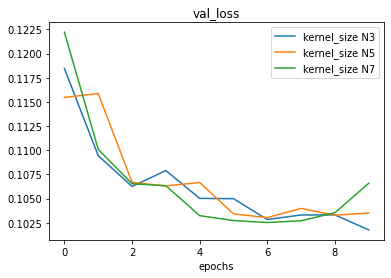

In [14]:
df_score = pd.DataFrame(columns=['epochs']).set_index('epochs')

for i in [3, 5, 7]:
    conv_model = models.Sequential([
        layers.Conv1D(filters=8, kernel_size=i, activation='relu'),

        layers.GlobalMaxPool1D(),

        layers.Dense(10, activation='relu'),
        layers.Dense(2, activation='softmax'),
    ]) # init model

    conv_model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    ) # compile model

    history = conv_model.fit(
        X_train_wv, y_train_cat, 
        batch_size=BATCH_SIZE,
        epochs=10,
        validation_data=(X_val_wv, y_val_cat),
        verbose=0
    ) # fitting model
    
    df_score[f'kernel_size N{i}'] = history.history['val_loss'] # add vak_loss in df_score

# view plots
df_score.plot(title='val_loss')
df_score # view df

При 7 наступает переобучение, оптимальный вариант - 3. 

,loss
epochs,
0,0.112118
1,0.105882
2,0.101489
3,0.100469
4,0.099537
5,0.100247
6,0.099422
7,0.099023
8,0.099704


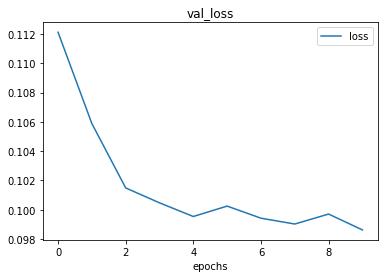

In [15]:
df_score = pd.DataFrame(columns=['epochs']).set_index('epochs')

conv_model = models.Sequential([
    layers.Conv1D(filters=8, kernel_size=3, activation='relu'),
    layers.Conv1D(filters=16, kernel_size=3, activation='relu'),

    layers.GlobalMaxPool1D(),

    layers.Dense(10, activation='relu'),
    layers.Dense(2, activation='softmax'),
]) # init model

conv_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
) # compile model

history = conv_model.fit(
    X_train_wv, y_train_cat, 
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(X_val_wv, y_val_cat),
    verbose=0
) # fitting model

df_score[f'loss'] = history.history['val_loss'] # add vak_loss in df_score

# view plots
df_score.plot(title='val_loss')
df_score # view df

Добавление дополнительного слоя снижает ошибку

2. построить различные архитектуры с RNN

,units N4,units N8,units N16,units N32
epochs,,,,
0,0.261301,0.243006,0.239194,0.236358
1,0.249487,0.239147,0.240018,0.208978
2,0.248246,0.236321,0.207259,0.202574
3,0.246859,0.231554,0.223423,0.208512
4,0.245410,0.235126,0.207012,0.224109
5,0.243652,0.238139,0.203899,0.233210
6,0.243880,0.233754,0.199780,0.208575
7,0.244417,0.231373,0.196237,0.203395
8,0.243850,0.210798,0.170197,0.197136


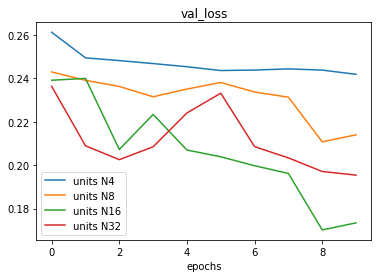

In [16]:
df_score = pd.DataFrame(columns=['epochs']).set_index('epochs')

for i in [4, 8, 16, 32]:
    conv_model = models.Sequential([
        layers.SimpleRNN(units=i),

        layers.Dense(10, activation='relu'),
        layers.Dense(2, activation='softmax'),
    ]) # init model

    conv_model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    ) # compile model

    history = conv_model.fit(
        X_train_wv, y_train_cat, 
        batch_size=BATCH_SIZE,
        epochs=10,
        validation_data=(X_val_wv, y_val_cat),
        verbose=0
    ) # fitting model
    
    df_score[f'units N{i}'] = history.history['val_loss'] # add vak_loss in df_score

# view plots
df_score.plot(title='val_loss')
df_score # view df

16 юнитов в RNN дает оптимальный результат

3. попробовать использовать совместно CNN и RNN

,units N4,units N8,units N16,units N32
epochs,,,,
0,0.240553,0.236268,0.235655,0.202266
1,0.235537,0.227555,0.207510,0.200035
2,0.237736,0.222768,0.196753,0.240168
3,0.232659,0.209343,0.198314,0.196675
4,0.219118,0.211018,0.233359,0.196332
5,0.155965,0.203659,0.194910,0.236704
6,0.260971,0.204346,0.162644,0.206135
7,0.234755,0.185143,0.202462,0.197215
8,0.212540,0.202218,0.196906,0.195667


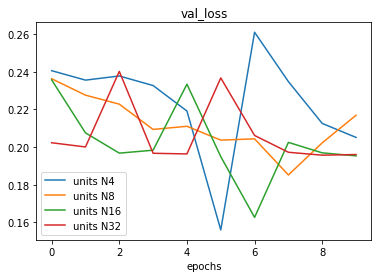

In [18]:
df_score = pd.DataFrame(columns=['epochs']).set_index('epochs')

for i in [4, 8, 16, 32]:
    conv_model = models.Sequential([
        layers.Conv1D(filters=8, kernel_size=3, activation='relu'),
        layers.SimpleRNN(units=i),

        layers.Dense(10, activation='relu'),
        layers.Dense(2, activation='softmax'),
    ]) # init model

    conv_model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    ) # compile model

    history = conv_model.fit(
        X_train_wv, y_train_cat, 
        batch_size=BATCH_SIZE,
        epochs=10,
        validation_data=(X_val_wv, y_val_cat),
        verbose=0
    ) # fitting model
    
    df_score[f'units N{i}'] = history.history['val_loss'] # add vak_loss in df_score

# view plots
df_score.plot(title='val_loss')
df_score # view df

4. сделать выводы что получилось лучше

In [14]:
лучший результат получился при добавлении дополнительного слоя в CNN